## Data Preprocess for real data
Including following tasks
- Data selection for given time period
- Find target route using K-means clustering
- Determine waypoints (intermediate nodes) using DBSCAN
- Extract sub-grids and save

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math

from itertools import permutations
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

np.random.seed(12345)

In [2]:
if not os.path.exists('out'):
    os.mkdir('out')

In [3]:
PATH_START = (121.46, 31.22) #(CNWGQ: 31.22N, 121.46E) 
PATH_END = (174.77, -36.87) #(NZAKL: 36.87S 174.77E)
PATH_STOP = (129.04, 35.103) #(KRPUS: 35.103N, 129.04E)
THRESHOLD = 0.5

In [4]:
df = pd.read_csv('rf_dtmmsi.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,TRKG_NO,MMSI_CD,VSL_NM,AIS_DATETIME,LAT,LON,SPD
0,VTR2014041610008,209752000_4,NOBLE REGOR,20140428132100,31.1663,122.1978,63.0
1,VTR2014041610008,209752000_4,NOBLE REGOR,20140428133154,31.1811,122.1737,82.0
2,VTR2014041610008,209752000_4,NOBLE REGOR,20140428134204,31.1953,122.1506,81.0
3,VTR2014041610008,209752000_4,NOBLE REGOR,20140428135115,31.2116,122.1250,99.0
4,VTR2014041610008,209752000_4,NOBLE REGOR,20140428140124,31.2301,122.0927,102.0
...,...,...,...,...,...,...,...
19199,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811125806,-40.4581,177.1012,131.0
19200,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811142137,-40.7383,176.8104,129.0
19201,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811203557,-41.9590,175.5246,125.0
19202,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811205147,-42.0084,175.4731,123.0


In [5]:
len(df['TRKG_NO'].unique()), len(df['MMSI_CD'].unique()), len(df['VSL_NM'].unique())

(18, 9, 5)

In [6]:
df.groupby(['TRKG_NO', 'MMSI_CD']).size()

TRKG_NO           MMSI_CD    
VTR2014041610008  209752000_4     339
VTR2014041723249  209752000_4     737
VTR2014041936662  209752000_4     299
VTR2014050136065  218575000_5    1361
VTR2014050239888  218575000_5    1243
VTR2014050240160  218575000_5    1653
VTR2014052283395  218485000_6    1257
VTR2014052942937  305096000_6     624
VTR2014053056437  218485000_5    1052
VTR2014060695787  209752000_6     784
VTR2014061238208  636091255_6     984
VTR2014061240704  636091255_6    1316
VTR2014061354223  636091255_6    1249
VTR2014061354240  636091255_6    1228
VTR2014061773692  218575000_6    1733
VTR2014062008681  218575000_6    1351
VTR2014071054804  218485000_7    1010
VTR2014071815805  218485000_7     984
dtype: int64

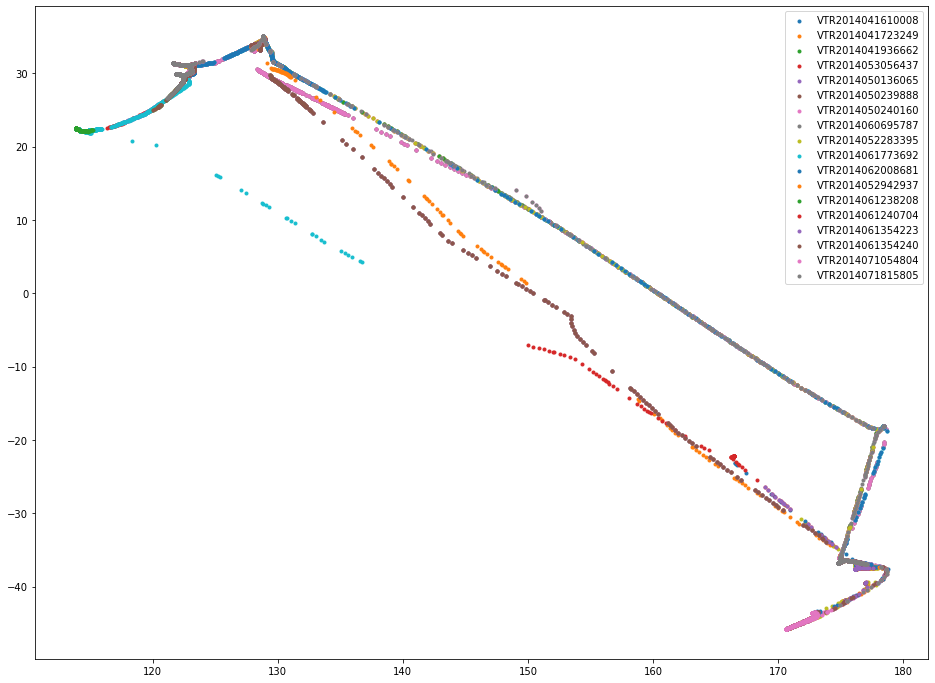

In [7]:
plt.figure(figsize=(16,12))
for idx in df['TRKG_NO'].unique():
    df_selected = df[df['TRKG_NO']==idx]
    plt.scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
plt.legend(df['TRKG_NO'].unique())
plt.show()

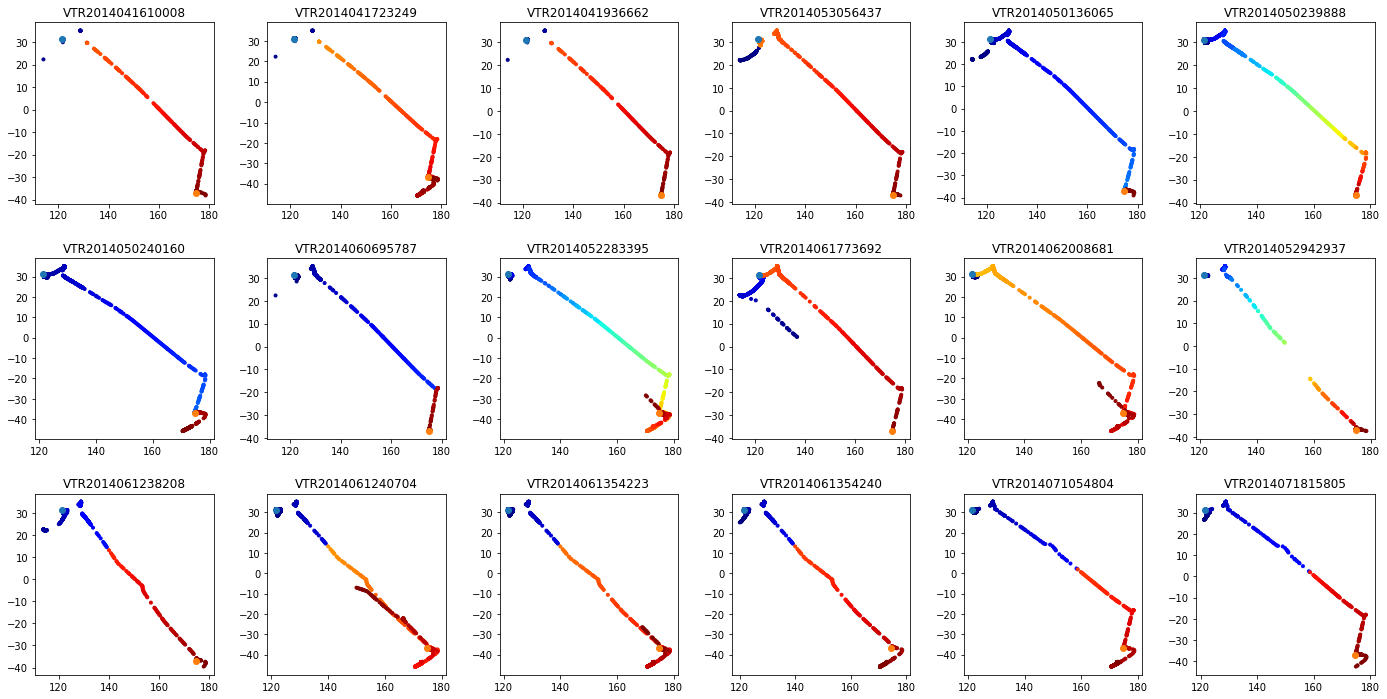

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for row in ax:
    for col in row:
        idx = df['TRKG_NO'].unique()[i]
        df_selected = df[df['TRKG_NO']==idx]
        col.scatter(x=df_selected['LON'], y=df_selected['LAT'], c=df_selected['AIS_DATETIME'], cmap='jet', marker='.')
        col.scatter(x=PATH_START[0], y=PATH_START[1])
        col.scatter(x=PATH_END[0], y=PATH_END[1])
        col.set_title(idx)
        i += 1

In [9]:
df_filtered_list = []
for idx in df['TRKG_NO'].unique():
    df_selected = df[df['TRKG_NO']==idx]
    
    # Sort the value by AIS datetime
    df_selected_sorted = df_selected.copy()
    df_selected_sorted.sort_values(by=['AIS_DATETIME'], ascending=True , inplace=True)
    df_selected = df_selected_sorted
    
    # selected data point near start region
    df_selected_start = df_selected[df_selected['LON'].between(PATH_START[0]-THRESHOLD, PATH_START[0]+THRESHOLD) 
                                    & df_selected['LAT'].between(PATH_START[1]-THRESHOLD, PATH_START[1]+THRESHOLD)]
    start_datetime = df_selected_start.iloc[-1]['AIS_DATETIME']

    # selected data point near end region
    df_selected_end = df_selected[df_selected['LON'].between(PATH_END[0]-THRESHOLD, PATH_END[0]+THRESHOLD)
                                 & df_selected['LAT'].between(PATH_END[1]-THRESHOLD, PATH_END[1]+THRESHOLD)]
    end_datetime = df_selected_end.iloc[0]['AIS_DATETIME']
    
    # only use the data between start_datetime and end_datetime
    df_selected_filtered = df_selected[df_selected['AIS_DATETIME'].between(start_datetime, end_datetime)]
    df_filtered_list.append(df_selected_filtered)
    print('Filter data {}: {} / {}'.format(idx, len(df_selected_filtered), len(df_selected))) 

Filter data VTR2014041610008: 194 / 339
Filter data VTR2014041723249: 194 / 737
Filter data VTR2014041936662: 195 / 299
Filter data VTR2014053056437: 360 / 1052
Filter data VTR2014050136065: 689 / 1361
Filter data VTR2014050239888: 607 / 1243
Filter data VTR2014050240160: 607 / 1653
Filter data VTR2014060695787: 367 / 784
Filter data VTR2014052283395: 360 / 1257
Filter data VTR2014061773692: 503 / 1733
Filter data VTR2014062008681: 503 / 1351
Filter data VTR2014052942937: 263 / 624
Filter data VTR2014061238208: 379 / 984
Filter data VTR2014061240704: 343 / 1316
Filter data VTR2014061354223: 343 / 1249
Filter data VTR2014061354240: 343 / 1228
Filter data VTR2014071054804: 242 / 1010
Filter data VTR2014071815805: 242 / 984


In [10]:
df_filtered = pd.concat(df_filtered_list)

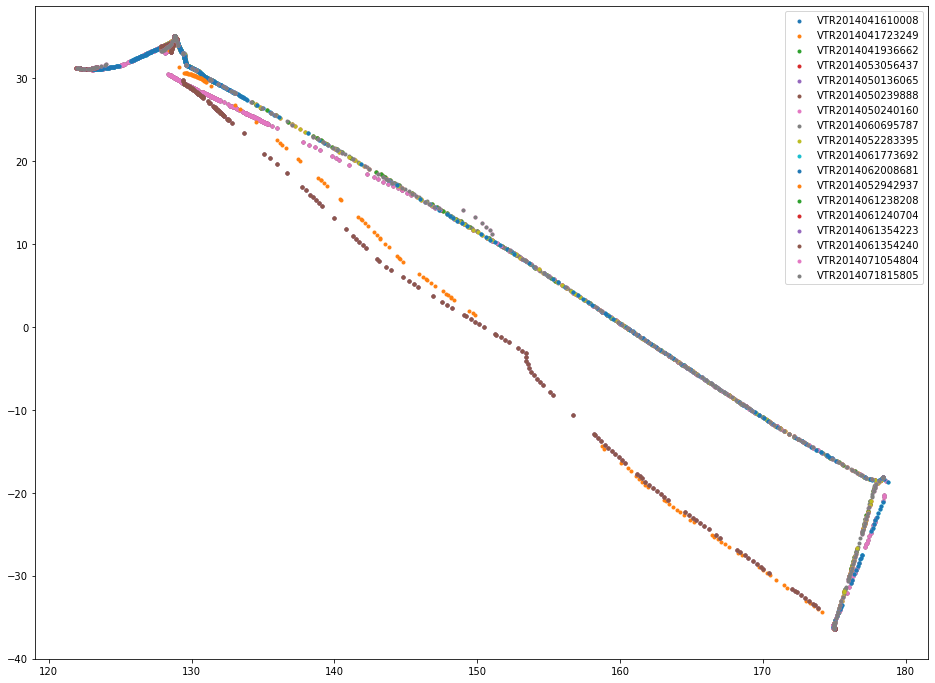

In [11]:
plt.figure(figsize=(16,12))
for idx in df_filtered['TRKG_NO'].unique():
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]
    plt.scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
plt.legend(df['TRKG_NO'].unique())
plt.show()

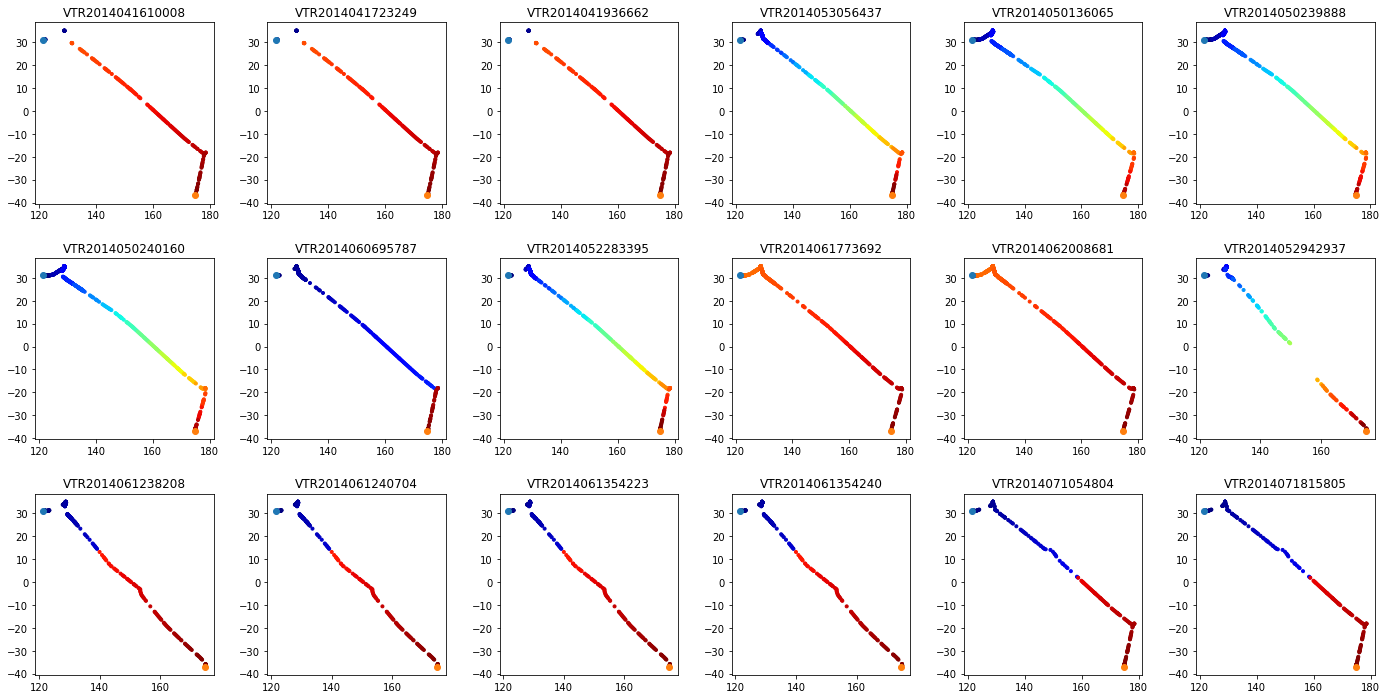

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for row in ax:
    for col in row:
        idx = df_filtered['TRKG_NO'].unique()[i]
        df_selected = df_filtered[df_filtered['TRKG_NO']==idx]
        col.scatter(x=df_selected['LON'], y=df_selected['LAT'], c=df_selected['AIS_DATETIME'], cmap='jet', marker='.')
        col.scatter(x=PATH_START[0], y=PATH_START[1])
        col.scatter(x=PATH_END[0], y=PATH_END[1])
        col.set_title(idx)
        i += 1

In [13]:
x_lat = np.asarray(df_filtered['LAT']).T
x_lon = np.asarray(df_filtered['LON']).T

x_edge = range(math.floor(min(x_lon)), math.ceil(max(x_lon))+1)
y_edge = range(math.floor(min(x_lat)), math.ceil(max(x_lat))+1)

In [14]:
df_matrix_list = []
for idx in df_filtered['TRKG_NO'].unique():
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]
    df_selected_lat = np.asarray(df_selected['LAT']).T
    df_selected_lon = np.asarray(df_selected['LON']).T
    
    H, xedges, yedges = np.histogram2d(df_selected_lon, df_selected_lat, bins=(x_edge, y_edge))
    H = H.T
    H_filp = np.flipud(H)
    
    df_matrix_list.append(H_filp)

In [15]:
H, xedges, yedges = np.histogram2d(x_lon, x_lat, bins=(x_edge, y_edge))
H = H.T
H_filp = np.flipud(H)

In [16]:
import pickle
out_name = 'out/map_matrix'
with open(out_name, 'wb') as f:
    pickle.dump(H_filp, f)

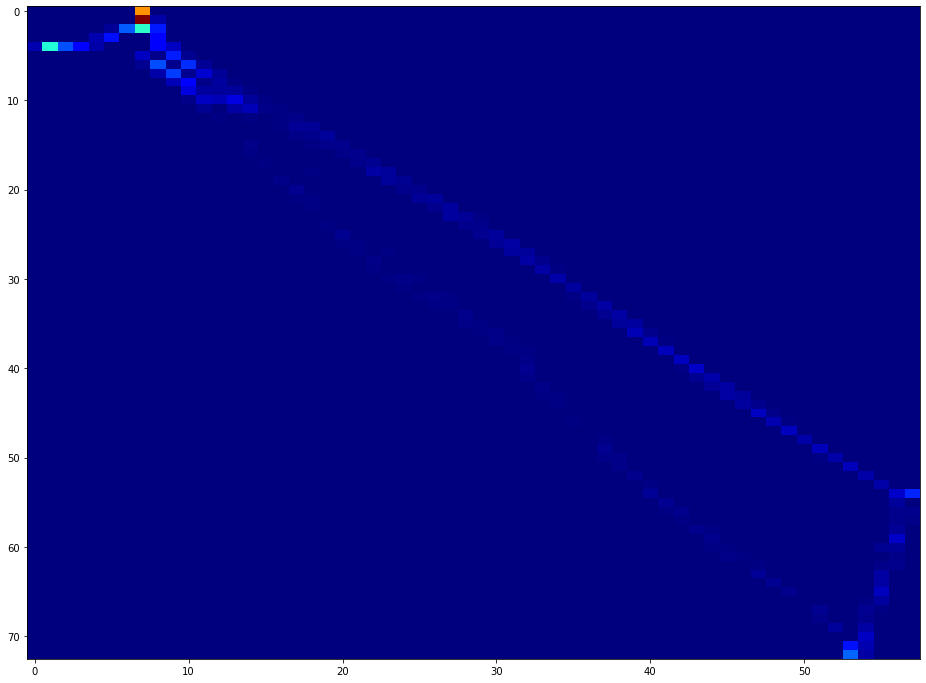

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_filp, cmap='jet', aspect='auto')

In [18]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)

data = np.vstack([np.array(element.reshape(1,-1)) for element in df_matrix_list])
k_means.fit(data)

cluster = k_means.predict(data)

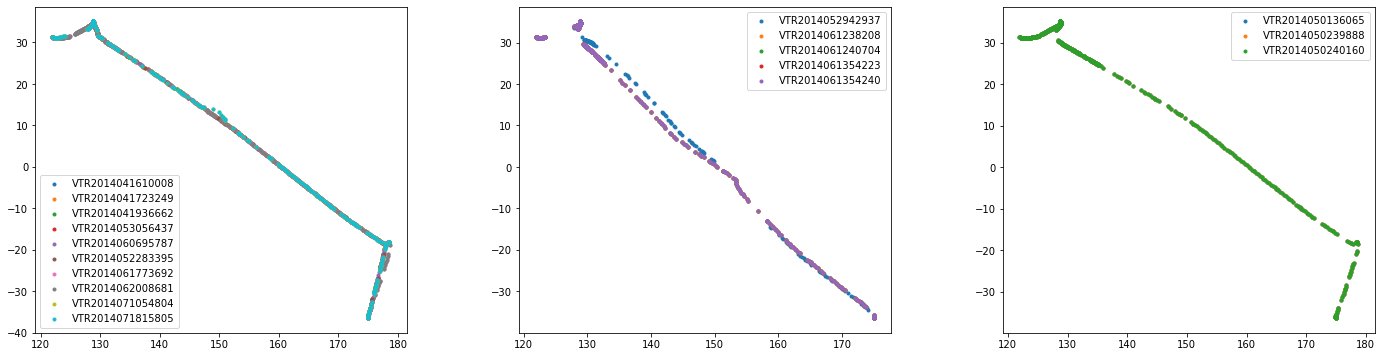

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

df_cluster_0 = []
df_cluster_1 = []
df_cluster_2 = []

legend_0 = []
legend_1 = []
legend_2 = []

for idx, c in zip(df_filtered['TRKG_NO'].unique(), cluster):
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]

    if c == 0:
        df_cluster_0.append(df_selected)
        ax[0].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
        legend_0.append(idx)
    elif c == 1:
        df_cluster_1.append(df_selected)
        ax[1].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.') 
        legend_1.append(idx)
    elif c == 2:
        df_cluster_2.append(df_selected)
        ax[2].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.') 
        legend_2.append(idx)
        
ax[0].legend(legend_0)
ax[1].legend(legend_1)
ax[2].legend(legend_2)

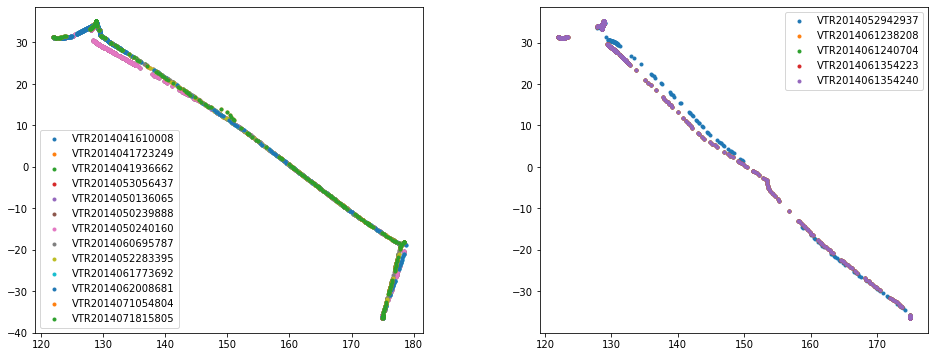

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

legend_0 = []
legend_1 = []

for idx, c in zip(df_filtered['TRKG_NO'].unique(), cluster):
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]

    if c == 0 or c == 2:
        ax[0].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
        legend_0.append(idx)
    elif c == 1:
        ax[1].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.') 
        legend_1.append(idx)
        
ax[0].legend(legend_0)
ax[1].legend(legend_1)

In [21]:
#Assume cluster 0 & cluster 2 as similar travel path
#df_target = pd.concat(df_cluster_0) #Consider cluster 0 only
df_target = pd.concat(df_cluster_0+df_cluster_2)

In [22]:
df_target

,TRKG_NO,MMSI_CD,VSL_NM,AIS_DATETIME,LAT,LON,SPD
62,VTR2014041610008,209752000_4,NOBLE REGOR,20140429054233,31.2543,121.9454,107.0
63,VTR2014041610008,209752000_4,NOBLE REGOR,20140429055154,31.2481,121.9832,110.0
64,VTR2014041610008,209752000_4,NOBLE REGOR,20140429060253,31.2409,122.0290,117.0
65,VTR2014041610008,209752000_4,NOBLE REGOR,20140429061227,31.2341,122.0720,122.0
66,VTR2014041610008,209752000_4,NOBLE REGOR,20140429062145,31.2189,122.1124,131.0
...,...,...,...,...,...,...,...
6318,VTR2014050240160,218575000_5,HANSA VICTORY,20140530232130,-36.2502,174.9288,100.0
6319,VTR2014050240160,218575000_5,HANSA VICTORY,20140530233203,-36.2835,174.9389,99.0
6320,VTR2014050240160,218575000_5,HANSA VICTORY,20140530234108,-36.3126,174.9475,100.0
6321,VTR2014050240160,218575000_5,HANSA VICTORY,20140530235208,-36.3472,174.9578,101.0


In [23]:
df_target[['LAT', 'LON']].to_csv('target_raw.csv', index=False)

In [24]:
df_target_list = []
for trkg_id in df_target['TRKG_NO'].unique():
    df_selected = df_target[df_target['TRKG_NO'] == trkg_id]
    df_selected = df_selected.reset_index()
    min_AIS_datetime = min(df_selected['AIS_DATETIME'])
    max_AIS_datetime = max(df_selected['AIS_DATETIME'])
    df_selected['Time'] = [round((datetime - min_AIS_datetime) / (max_AIS_datetime-min_AIS_datetime), 3) for datetime in list(df_selected['AIS_DATETIME'])]
    df_target_list.append(df_selected)
df_target_adjusted = pd.concat(df_target_list) 
df_target = df_target_adjusted

In [25]:
x_lat_target = np.asarray(df_target['LAT']).T
x_lon_target = np.asarray(df_target['LON']).T

#x_edge = range(math.floor(min(x_lon)), math.ceil(max(x_lon))+1)
#y_edge = range(math.floor(min(x_lat)), math.ceil(max(x_lat))+1)

In [26]:
H_target, xedges, yedges = np.histogram2d(x_lon_target, x_lat_target, bins=(x_edge, y_edge))
H_target = H_target.T
H_target_filp = np.flipud(H_target)

In [27]:
H_target_filp.shape

(73, 58)

In [28]:
import pickle
out_name = 'out/map_matrix_target'
with open(out_name, 'wb') as f:
    pickle.dump(H_target_filp, f)

In [29]:
PATH_START_CELL = (math.floor(PATH_START[0]) - math.floor(min(x_lon)), math.ceil(max(x_lat)) - math.ceil(PATH_START[1]))
PATH_START_CELL

(0, 4)

In [30]:
PATH_END_CELL = (math.floor(PATH_END[0]) - math.floor(min(x_lon)), math.ceil(max(x_lat)) - math.ceil(PATH_END[1]))
PATH_END_CELL

(53, 72)

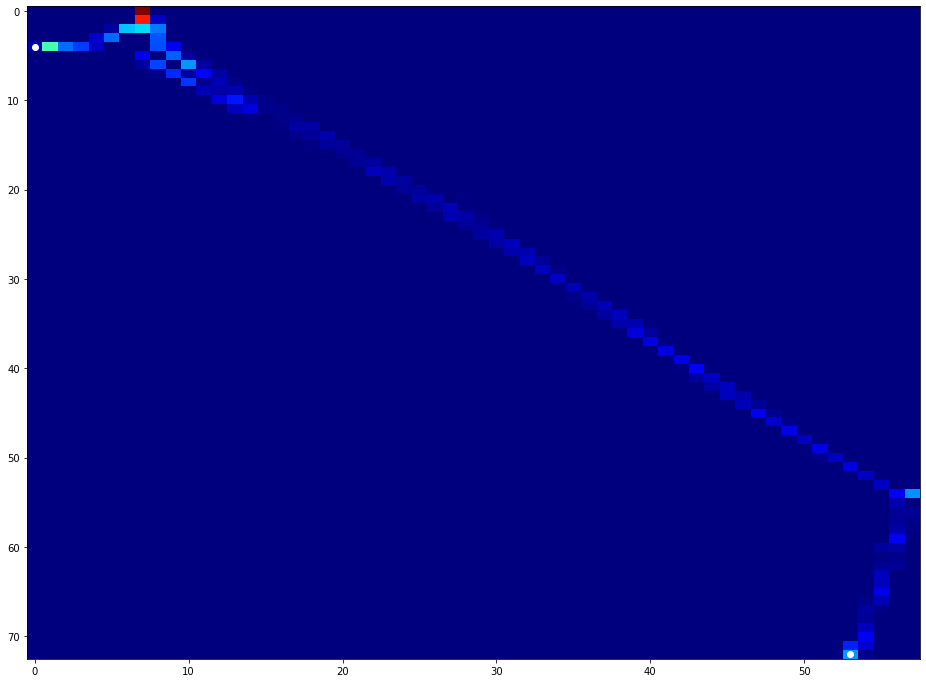

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(PATH_START_CELL[0], PATH_START_CELL[1], c='white')
ax.scatter(PATH_END_CELL[0], PATH_END_CELL[1], c='white')

In [32]:
X = H_target_filp
X_csr = csr_matrix(X)
X_coo = X_csr.tocoo()

In [33]:
X.shape

(73, 58)

In [34]:
X.shape[0] * X.shape[1]

4234

In [35]:
len(X_coo.data)

159

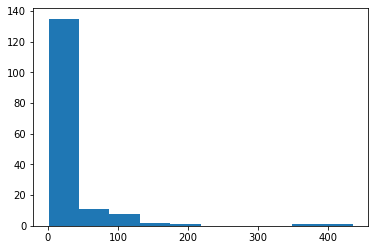

In [36]:
plt.hist(X_coo.data)
plt.show()

In [37]:
np.sum(X_csr.data >= np.quantile(X_coo.data, 0.9)), len(X_csr.data)

(16, 159)

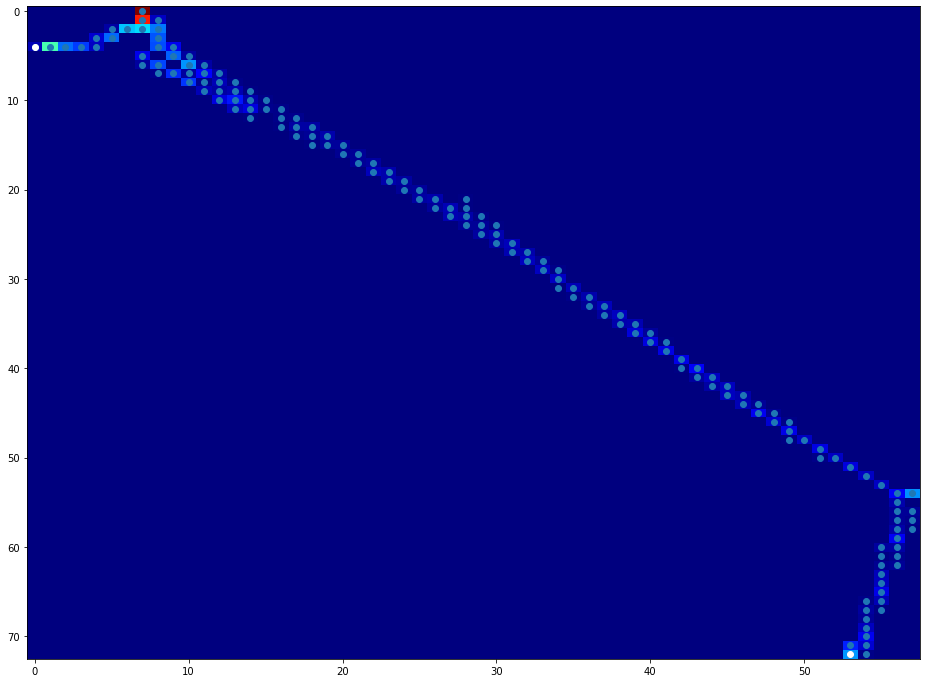

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(X_coo.col, X_coo.row)
ax.scatter(PATH_START_CELL[0], PATH_START_CELL[1], c='white')
ax.scatter(PATH_END_CELL[0], PATH_END_CELL[1], c='white')

In [39]:
LON_edges = xedges
LAT_edges = yedges[::-1]

In [40]:
X_x = []
X_y = []
X_data = []

for col, row, data in zip(X_coo.col, X_coo.row, X_coo.data):
    if data > np.median(X_coo.data):
        X_x.append(col)
        X_y.append(row)
        X_data.append(data)

X_x = np.array(X_x)
X_y = np.array(X_y)
X_data = np.array(X_data)

In [41]:
X_cell_data = np.vstack([X_x, X_y, X_data]).T

In [42]:
imp_cell_top = []
for x, y, data in X_cell_data[X_cell_data[:,2].argsort()[::-1]]:
    imp_cell_top.append((int(x),int(y), int(data)))
imp_cell_top = imp_cell_top

In [43]:
imp_cell_top_selected =[]
for x, y, data in imp_cell_top:
    if x == PATH_START_CELL[0] and y == PATH_START_CELL[1]:
        continue
    if x == PATH_END_CELL[0] and y == PATH_END_CELL[1]:
        continue
    imp_cell_top_selected.append((int(x), int(y), int(data)))

In [44]:
#Ignore stopped trkg id = VTR2014061773692 or VTR2014062008681
#Consider one trkg id only VTR2014050239888

imp_cell_list = []
for cell in imp_cell_top_selected:
    df_filtered = df_target[(df_target['LON'] >= LON_edges[cell[0]]) & (df_target['LON'] < LON_edges[cell[0]+1])]
    df_filtered = df_filtered[(df_filtered['LAT'] >= LAT_edges[cell[1]]-1) & (df_filtered['LAT'] < LAT_edges[cell[1]])]
    df_filtered_selected = df_filtered[df_filtered['TRKG_NO'] == df_target['TRKG_NO'].unique()[0]]    
    if (len(df_filtered_selected)) != 0:
        seq = df_filtered_selected['Time'].mean()
        imp_cell_list.append(np.array([int(cell[0]), int(cell[1]), int(cell[2]), float(seq)], dtype=object))

In [45]:
imp_cell = np.vstack(imp_cell_list)

In [46]:
imp_cell = imp_cell[imp_cell[:,2].argsort()[::-1]]

In [47]:
imp_cell_start = np.array([int(PATH_START_CELL[0]), int(PATH_START_CELL[1]), int(-1), 0.0], dtype=object)
imp_cell_end = np.array([int(PATH_END_CELL[0]), int(PATH_END_CELL[1]), int(-1), 1.0], dtype=object)
imp_cell_sorted = np.vstack([imp_cell_start, imp_cell_end, imp_cell])

In [48]:
len(imp_cell_sorted)

51

In [49]:
imp_cell_filtered = [None]
cnt = 0
while (cnt != len(imp_cell_filtered)):
    imp_cell_filtered = []
    for x_s, y_s, data_s, seq_s in imp_cell_sorted[:cnt+1]:
        imp_cell_filtered.append(np.array([int(x_s), int(y_s), int(data_s), seq_s], dtype=object))

    x_e, y_e, data_e, seq_e = imp_cell_sorted[cnt]
    for x_s, y_s, data_s, seq_s in imp_cell_sorted[cnt+1:]:
        m_dist = abs(x_e-x_s)+abs(y_e-y_s)
        if m_dist > 5:
            imp_cell_filtered.append(np.array([int(x_s), int(y_s), int(data_s), seq_s], dtype=object))
    imp_cell_sorted = np.vstack(imp_cell_filtered)
    cnt = cnt+1
    print(len(imp_cell_sorted))

50
46
46
46
43
38
37
34
32
29
25
23
23
21
21
19
18
18


In [50]:
imp_cell_selected = imp_cell_sorted[imp_cell_sorted[:,3].argsort()]
imp_cell_selected

array([[0, 4, -1, 0.0],
       [7, 0, 435, 0.012272727272727274],
       [10, 6, 118, 0.8277142857142855],
       [13, 9, 19, 0.8306666666666667],
       [19, 14, 18, 0.8425],
       [22, 18, 23, 0.853],
       [27, 22, 21, 0.865],
       [31, 26, 23, 0.876],
       [34, 30, 26, 0.8865000000000001],
       [37, 33, 23, 0.897],
       [40, 37, 36, 0.9049999999999999],
       [43, 40, 46, 0.91],
       [47, 45, 43, 0.922],
       [51, 49, 38, 0.933],
       [57, 54, 116, 0.9565],
       [56, 59, 45, 0.9695],
       [55, 65, 40, 0.98125],
       [53, 72, -1, 1.0]], dtype=object)

In [51]:
imp_cell = imp_cell_selected

In [52]:
len(imp_cell)

18

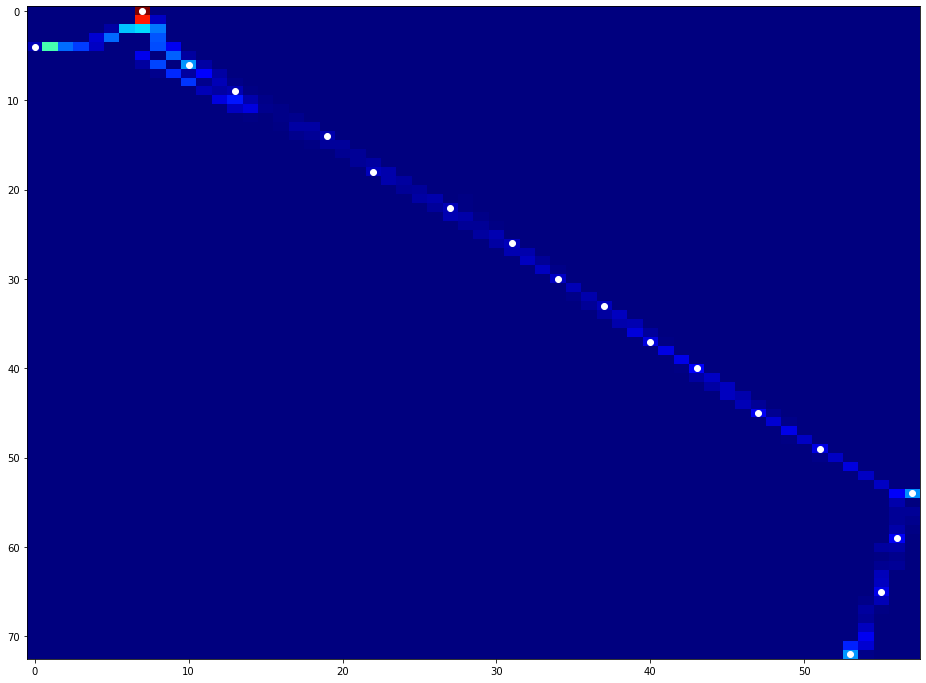

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(imp_cell[:,0], imp_cell[:,1], c='white')

In [54]:
def get_n_routes(grid):
    n_routes = math.factorial(grid.shape[0]-1+grid.shape[1]-1)/math.factorial(grid.shape[0]-1)/math.factorial(grid.shape[1]-1)
    return int(n_routes)

In [55]:
M_DIST_MAX = 13
grid_list = []
grid_info_list = []

for (x_s,y_s), (x_e,y_e) in zip(imp_cell[:-1][:,0:2], imp_cell[1:][:,0:2]):
    x_d = 1 #rightward
    if x_s >= x_e:
        tmp = x_s
        x_s = x_e
        x_e = tmp
        x_d = -1 #leftward
    y_d = 1 #downward
    if y_s >= y_e:
        tmp = y_s
        y_s = y_e
        y_e = tmp
        y_d = -1 #upward

    x_s, y_s, x_e, y_e = int(x_s), int(y_s), int(x_e), int(y_e)
    
    grid = H_target_filp[y_s:y_e+1, x_s:x_e+1] #matrix indexing (row,col)
    m_dist = grid.shape[0]-1 + grid.shape[1]-1        
    n_routes = get_n_routes(grid)
    
    if m_dist <= M_DIST_MAX:
        grid_list.append(grid)
        grid_info_list.append([x_s, y_s, x_e, y_e, x_d, y_d])
        print(m_dist, n_routes)
    else:
        if x_d == -1: grid = np.fliplr(grid)
        if y_d == -1: grid = np.flipud(grid)            

        # if m_dist is larger than threshold, divide it into smaller one
        sub_grids = []
        while m_dist > M_DIST_MAX:
            grid_coo = csr_matrix(grid).tocoo()
            grid_value = np.array([grid_coo.data, grid_coo.row, grid_coo.col]).T
            grid_value_sorted = grid_value[grid_value[:,0].argsort()[::-1]]

            for val, row, col in grid_value_sorted:
                if row+col < 6:
                    continue
                if row+col < 10:
                    row_mid = int(row)
                    col_mid = int(col)
                    break

            sub_grid_1 = grid[0:row_mid+1, 0:col_mid+1]
            sub_grid_2 = grid[row_mid:grid.shape[0]+1, col_mid:grid.shape[1]+1]

            if x_d == -1: sub_grid_1 = np.fliplr(sub_grid_1)
            if y_d == -1: sub_grid_1 = np.flipud(sub_grid_1)

            if x_d == -1: sub_grid_2 = np.fliplr(sub_grid_2)
            if y_d == -1: sub_grid_2 = np.flipud(sub_grid_2)
                
            sub_grids.append(sub_grid_1)
            grid = sub_grid_2
            m_dist = grid.shape[0]-1 + grid.shape[1]-1
            n_routes = get_n_routes(grid)
            
        sub_grids.append(grid)

        for sub in sub_grids:
            grid_list.append(sub)
            x_e = x_s + sub.shape[1]-1
            y_e = y_s + sub.shape[0]-1
            grid_info_list.append([x_s, y_s, x_e, y_e, x_d, y_d])
            x_s = x_e
            y_s = y_e
            m_dist = sub.shape[0]-1 + sub.shape[1]-1
            n_routes = get_n_routes(sub)
            print(m_dist, n_routes)

11 330
9 84
6 20
11 462
7 35
9 126
8 70
7 35
6 20
7 35
6 20
9 126
8 70
11 462
6 6
7 7
9 36


In [56]:
grid_info_list_adjust = []

for x_s, y_s, x_e, y_e, x_d, y_d in grid_info_list:
    if x_d == -1:
        tmp = x_s
        x_s = x_e
        x_e = tmp
    if y_d == -1:
        tmp = y_s
        y_s = y_e
        y_e = tmp
        y_d = -1 #upward
    grid_info_list_adjust.append([x_s, y_s, x_e, y_e, x_d, y_d])
    
grid_info_list = grid_info_list_adjust
grid_info_list

[[0, 4, 7, 0, 1, -1],
 [7, 0, 10, 6, 1, 1],
 [10, 6, 13, 9, 1, 1],
 [13, 9, 19, 14, 1, 1],
 [19, 14, 22, 18, 1, 1],
 [22, 18, 27, 22, 1, 1],
 [27, 22, 31, 26, 1, 1],
 [31, 26, 34, 30, 1, 1],
 [34, 30, 37, 33, 1, 1],
 [37, 33, 40, 37, 1, 1],
 [40, 37, 43, 40, 1, 1],
 [43, 40, 47, 45, 1, 1],
 [47, 45, 51, 49, 1, 1],
 [51, 49, 57, 54, 1, 1],
 [57, 54, 56, 59, -1, 1],
 [56, 59, 55, 65, -1, 1],
 [55, 65, 53, 72, -1, 1]]

In [57]:
for (x_s, y_s, x_e, y_e, x_d, y_d), grid in zip(grid_info_list, grid_list):
    print([x_s, y_s, x_e, y_e, x_d, y_d], grid.shape, grid.shape[0]+grid.shape[1]-1)

[0, 4, 7, 0, 1, -1] (5, 8) 12
[7, 0, 10, 6, 1, 1] (7, 4) 10
[10, 6, 13, 9, 1, 1] (4, 4) 7
[13, 9, 19, 14, 1, 1] (6, 7) 12
[19, 14, 22, 18, 1, 1] (5, 4) 8
[22, 18, 27, 22, 1, 1] (5, 6) 10
[27, 22, 31, 26, 1, 1] (5, 5) 9
[31, 26, 34, 30, 1, 1] (5, 4) 8
[34, 30, 37, 33, 1, 1] (4, 4) 7
[37, 33, 40, 37, 1, 1] (5, 4) 8
[40, 37, 43, 40, 1, 1] (4, 4) 7
[43, 40, 47, 45, 1, 1] (6, 5) 10
[47, 45, 51, 49, 1, 1] (5, 5) 9
[51, 49, 57, 54, 1, 1] (6, 7) 12
[57, 54, 56, 59, -1, 1] (6, 2) 7
[56, 59, 55, 65, -1, 1] (7, 2) 8
[55, 65, 53, 72, -1, 1] (8, 3) 10


In [58]:
len(grid_list)

17

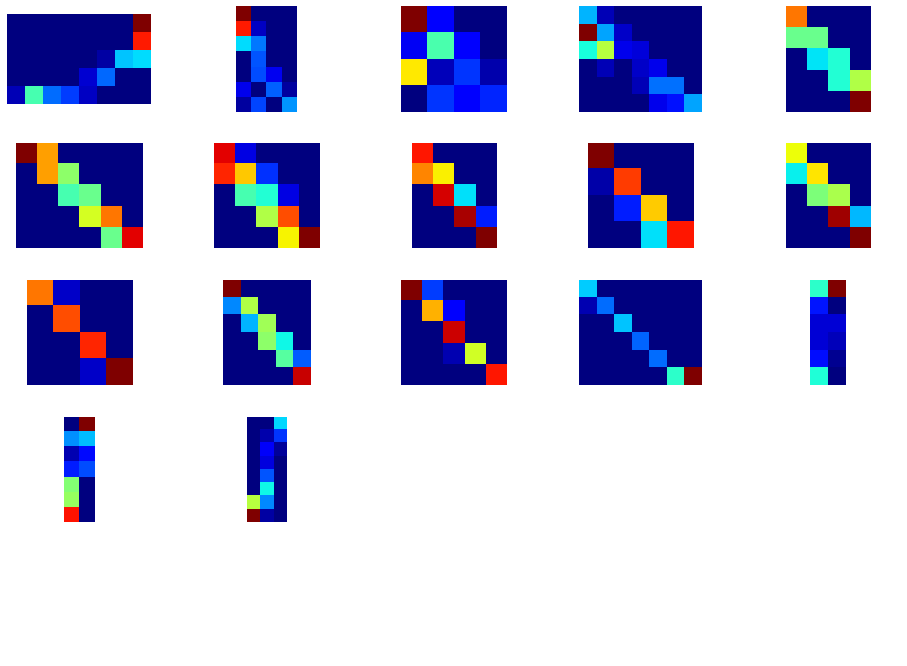

In [59]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for row in ax:
    for col in row:
        if i == len(grid_list):
            col.plot()
            col.axis('off')
            continue
        col.imshow(grid_list[i], cmap='jet')
        #for (j,i),label in np.ndenumerate(grid_list[i]):
        #    col.text(i,j,int(label),ha='center',va='center')
        col.axis('off')
        i += 1

In [60]:
grid_idx = ["{0:0=2d}".format(i) for i in range(len(grid_list))]

for grid, idx in zip(grid_list, grid_idx):
    pd.DataFrame(grid).to_csv(str('out/grid'+idx+'.csv'), index=False, header=False)

In [61]:
import pickle

out_name = 'out/grid_info_list'
with open(out_name, 'wb') as f:
    pickle.dump(grid_info_list, f)